### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [3]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 20.3 µs


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [7]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location
import sqlite3
DB_FILE_MLFLOW="lead_scoring_model_experimentation.db"
conn = sqlite3.connect(DB_FILE_MLFLOW)


In [ ]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''

In [9]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
TRACKING_URI="http://0.0.0.0:6006"
mlflow.set_tracking_uri(TRACKING_URI)

In [10]:
# setup pycaret 
import pycaret
print(pycaret.__version__)

2.3.8


In [11]:
Baseline_model_experiment01 = setup(data = dataset, target = 'app_complete_flag',
                       session_id = 42,fix_imbalance=False,
                       n_jobs=-1,use_gpu=False,
                       log_experiment=True,experiment_name='Baseline_model_experiment01',
                       log_plots=True, log_data=True,
                       silent=True, verbose=True,
                       log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


### 4 : Model Experimentation with pycaret

In [12]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
# Create a list of models to exclude
exclude_models = ['gbc', 'knn', 'qda', 'dummy', 'svm', 'ada']
#top_models = compare_models(include = [ 'xgboost'])
# Compare models with exclusion
top_models = compare_models(exclude=exclude_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7388,0.8211,0.8329,0.7027,0.7623,0.4770,0.4856,1.4140
xgboost,Extreme Gradient Boosting,0.7386,0.8211,0.8292,0.7037,0.7613,0.4766,0.4845,9.4790
rf,Random Forest Classifier,0.7372,0.8188,0.8245,0.7037,0.7593,0.4738,0.4811,3.1680
et,Extra Trees Classifier,0.7367,0.8180,0.8214,0.7043,0.7583,0.4730,0.4798,4.1320
dt,Decision Tree Classifier,0.7364,0.8170,0.8208,0.7041,0.7580,0.4723,0.4791,0.1650
lr,Logistic Regression,0.7099,0.7836,0.8221,0.6733,0.7403,0.4192,0.4299,1.2900
lda,Linear Discriminant Analysis,0.7005,0.7732,0.7962,0.6701,0.7278,0.4003,0.4077,0.3170
ridge,Ridge Classifier,0.7004,0.0000,0.7960,0.6702,0.7277,0.4002,0.4076,0.0530
nb,Naive Bayes,0.6625,0.7334,0.8931,0.6128,0.7268,0.3232,0.3646,0.0530


In [15]:
# create a model which gives the highest accuracy
lgbm  = create_model('lightgbm', fold = 5) 

In [16]:
# create feature importance plot
# %matplotlib inline

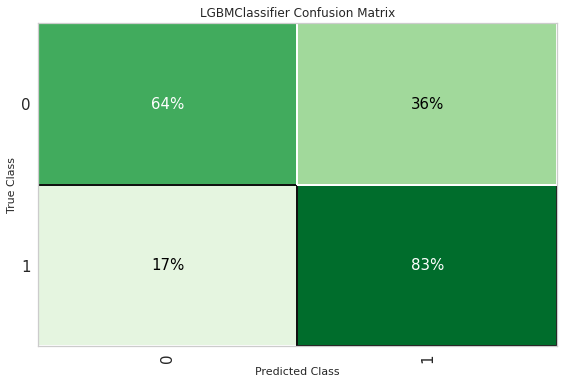

In [17]:
plot_model(lgbm, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

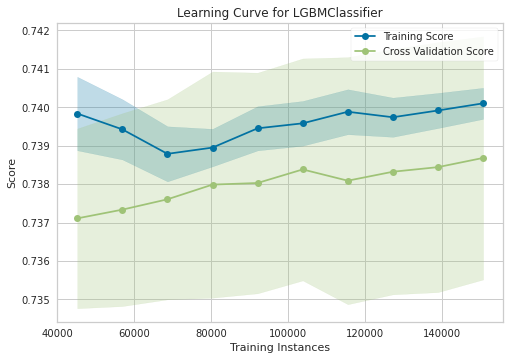

In [18]:
plot_model(lgbm, plot = 'learning')

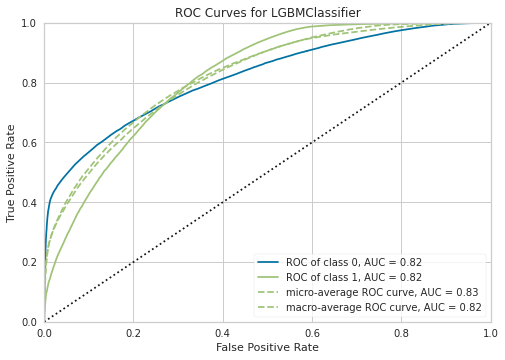

In [20]:
plot_model(lgbm, plot = 'auc')

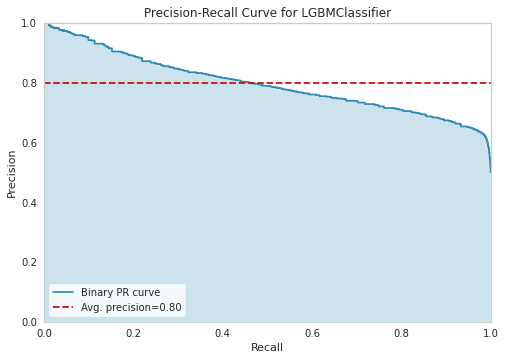

In [21]:
plot_model(lgbm, plot = 'pr')

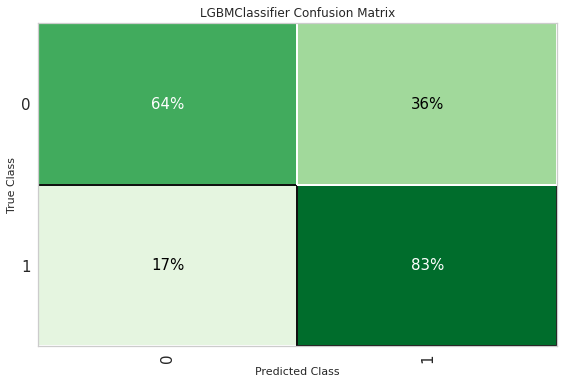

In [22]:
plot_model(lgbm, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

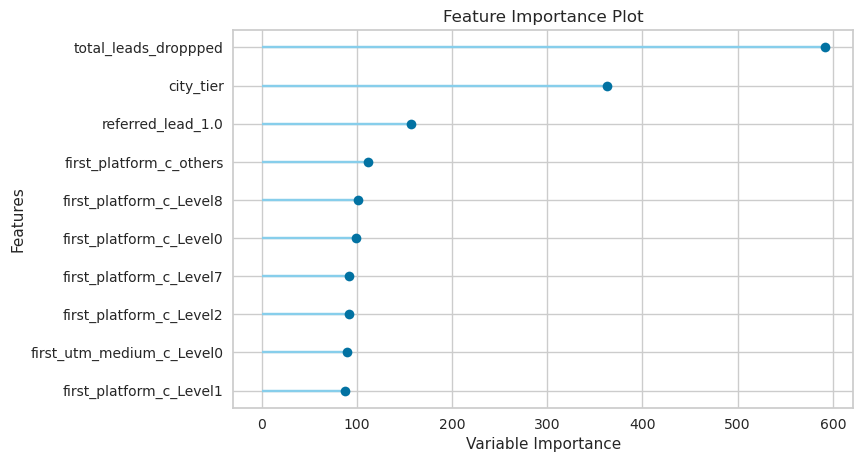

In [23]:
plot_model(lgbm, plot = 'feature')

In [26]:
!pip install shap

     |████████████████████████████████| 550 kB 6.1 MB/s eta 0:00:01


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


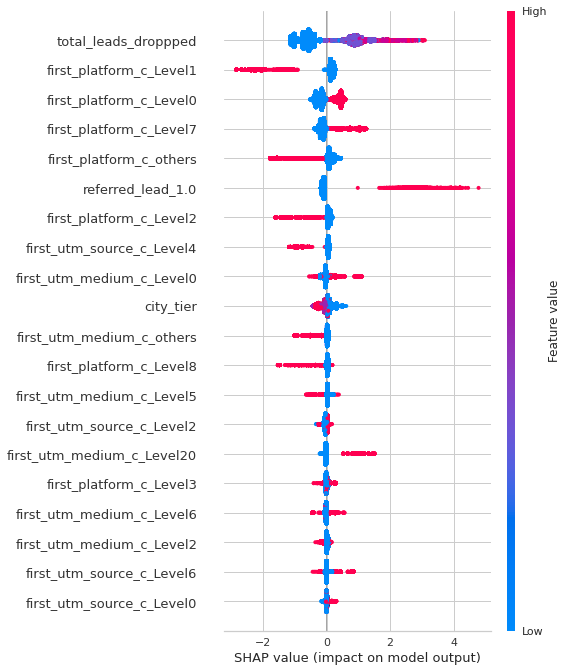

In [27]:
interpret_model(lgbm)

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [30]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#

print(dataset.columns)
data=dataset[['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']]
print(data.columns)




Index(['city_tier', 'first_platform_c', 'first_utm_medium_c',
       'first_utm_source_c', 'total_leads_droppped', 'referred_lead',
       'app_complete_flag', 'assistance_interaction', 'career_interaction',
       'payment_interaction', 'social_interaction', 'syllabus_interaction'],
      dtype='object')
Index(['total_leads_droppped', 'city_tier', 'referred_lead',
       'app_complete_flag', 'first_platform_c', 'first_utm_medium_c',
       'first_utm_source_c'],
      dtype='object')


/opt/conda/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/conda/lib

In [31]:
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

Significant_model_experiment01 = setup(data = dataset, target = 'app_complete_flag',
                       session_id = 42,fix_imbalance=False,
                       n_jobs=-1,use_gpu=False,
                       log_experiment=True,experiment_name='Significant_model_experiment01',
                       log_plots=True, log_data=True,
                       silent=True, verbose=True,
                       normalize = False,transformation = False,
                       log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [32]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada'].

# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
# Create a list of models to exclude
exclude_models = ['gbc', 'knn', 'qda', 'dummy', 'svm', 'ada']
#top_models = compare_models(include = [ 'xgboost'])
# Compare models with exclusion
top_models = compare_models(exclude=exclude_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7388,0.8211,0.8329,0.7027,0.7623,0.4770,0.4856,1.5130
xgboost,Extreme Gradient Boosting,0.7386,0.8211,0.8292,0.7037,0.7613,0.4766,0.4845,10.5980
rf,Random Forest Classifier,0.7372,0.8188,0.8245,0.7037,0.7593,0.4738,0.4811,3.1150
et,Extra Trees Classifier,0.7367,0.8180,0.8214,0.7043,0.7583,0.4730,0.4798,3.9810
dt,Decision Tree Classifier,0.7364,0.8170,0.8208,0.7041,0.7580,0.4723,0.4791,0.1580
lr,Logistic Regression,0.7099,0.7836,0.8221,0.6733,0.7403,0.4192,0.4299,1.3100
lda,Linear Discriminant Analysis,0.7005,0.7732,0.7962,0.6701,0.7278,0.4003,0.4077,0.3100
ridge,Ridge Classifier,0.7004,0.0000,0.7960,0.6702,0.7277,0.4002,0.4076,0.0530
nb,Naive Bayes,0.6625,0.7334,0.8931,0.6128,0.7268,0.3232,0.3646,0.0530


In [33]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
significant_lgbm  = create_model('lightgbm', fold = 5) 

In [35]:
!pip install  optuna

  Using cached optuna-3.3.0-py3-none-any.whl (404 kB)
  Using cached cmaes-0.10.0-py3-none-any.whl (29 kB)


In [39]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC

#num_leaves = trial.suggest_uniform('num_leaves', 10, 100)
#num_leaves = trial.suggest_int('num_leaves', 10, 100)
#num_leaves = trial.suggest_float('num_leaves', 10.0, 100.0)

tuned_lgbm_skopt,tuner_1 = tune_model(lgbm, 
                                   search_library = 'optuna',
                                   fold = 10 ,
                                   optimize = 'AUC',
                                   choose_better = True, 
                                   return_tuner=True)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:46:44
Status,. . . . . . . . . . . . . . . . . .,Creating Logs
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Split,Fold,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


ValueError: Deprecated distribution is specified in `actual_estimator__num_leaves` of param_distributions. Rejecting this because it may cause unexpected behavior. Please use new distributions such as FloatDistribution etc.

In [44]:
from sklearn.metrics import roc_auc_score
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        # Add other hyperparameters to optimize here
    }
    
    # Create a model with the current hyperparameters
    model = create_model('lightgbm', **params)

    # Evaluate the model using a metric of your choice (e.g., AUC)
    auc = roc_auc_score(get_config('y_test'), predict_model(model)['Score'])
    
    return auc

In [45]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # You can adjust the number of trials as needed

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7367,0.8170,0.8374,0.6973,0.7609,0.4734,0.4833


In [ ]:
# Print the final models configuration so that we can use it in the model retraining pipeline 